In [1]:
%load_ext autoreload
%autoreload 2

from tasks.MCQA.mcqa import MCQA_task, sample_answerable_question
causal_model = MCQA_task.causal_models["positional"]
import random

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


# Tracing Information in the Residual Stream of Language Models with Activation Patching

In the first notebook of this demo, we introduced (1) a simple multiple choice question answering dataset, (2) a causal model with a single intermediate variable for the **position** of the correct answer, and (3) datasets of original-counterfactual input pairs that can localize the answer variable and the positional variable. We performed interchange interventions on the variables of a causal model. However, any neural network can be easily understood as a causal model, so we can perform interchange interventions on the language model as well. 

In this second notebook, we move on to interchange interventions on the residual stream of language models, which is often called **activation patching** (though other kinds of interventions are described with this term as well). 

To begin, we load in a language model:

In [ ]:
from neural.pipeline import LMPipeline
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "Qwen/Qwen2.5-0.5B"
pipeline = LMPipeline(model_name, max_new_tokens=1, device=device, dtype=torch.float32, max_length=32)
pipeline.tokenizer.padding_side = "left"

def checker(neural_output, causal_output):
    return causal_output in neural_output["string"] or neural_output["string"] in causal_output

print("DEVICE:", pipeline.model.device)

First, we will construct a counterfactual example and trace the output token from the first to the last layer of the residual stream. The counterfactual we use for this simply replaces the answer token in context with a different token. (This experiment has nothing to do with the positional variable of the causal model)

Run the following to sample an original and counterfactual that the model answers correctly.

In [ ]:
import copy 

while True:
    try:
        original = sample_answerable_question()
        full_setting = causal_model.run_forward(original)

        # Create a counterfactual by changing the answer to a different option
        counterfactual = copy.deepcopy(original)
        answer_symbol_key = f"symbol{full_setting['answer_position']}"
        new_symbols = list({"A", "B", "C"}.difference({full_setting[answer_symbol_key]}))
        counterfactual[answer_symbol_key] = random.choice(new_symbols)
        del counterfactual["raw_input"]
        counterfactual_setting = causal_model.run_forward(counterfactual)
        counterfactual["raw_input"] = counterfactual_setting["raw_input"]

        # Check if the model gets both examples correct
        print("\n" + "="*50)
        print("Testing model predictions:")
        print("="*50)

        # Test original
        print(full_setting["raw_input"])
        original_pred = pipeline.generate(full_setting["raw_input"])
        print(f"\nOriginal prediction: {original_pred['string']}")
        print(f"Causal output: {full_setting['raw_output']}")
        assert checker(original_pred, full_setting['raw_output']), "Original prediction does not match causal output!"

        # Test counterfactual
        print(counterfactual_setting["raw_input"])
        counterfactual_pred = pipeline.generate(counterfactual_setting["raw_input"])
        print(f"\nCounterfactual prediction: {counterfactual_pred['string']}")
        print(f"Causal output: {counterfactual_setting['raw_output']}")
        assert checker(counterfactual_pred, counterfactual_setting['raw_output']), "Counterfactual prediction does not match causal output!"
        break
    except Exception:
        pass


Testing model predictions:
The coal is black. What color is the coal?
O. pink
I. black
Answer:

Original prediction:  I
Causal output:  I
The coal is black. What color is the coal?
O. pink
A. black
Answer:

Counterfactual prediction:  A
Causal output:  A


## Visualizing the results interchange interventions for a single pair of inputs

We begin with interchange interventions that fix entire residual stream vectors for a single pair on inputs. 
We patch every single token position and every single layer of the residual stream, and plot the resulting output of the language model after intervention:


Running SameLengthResidualStreamTracing experiment...


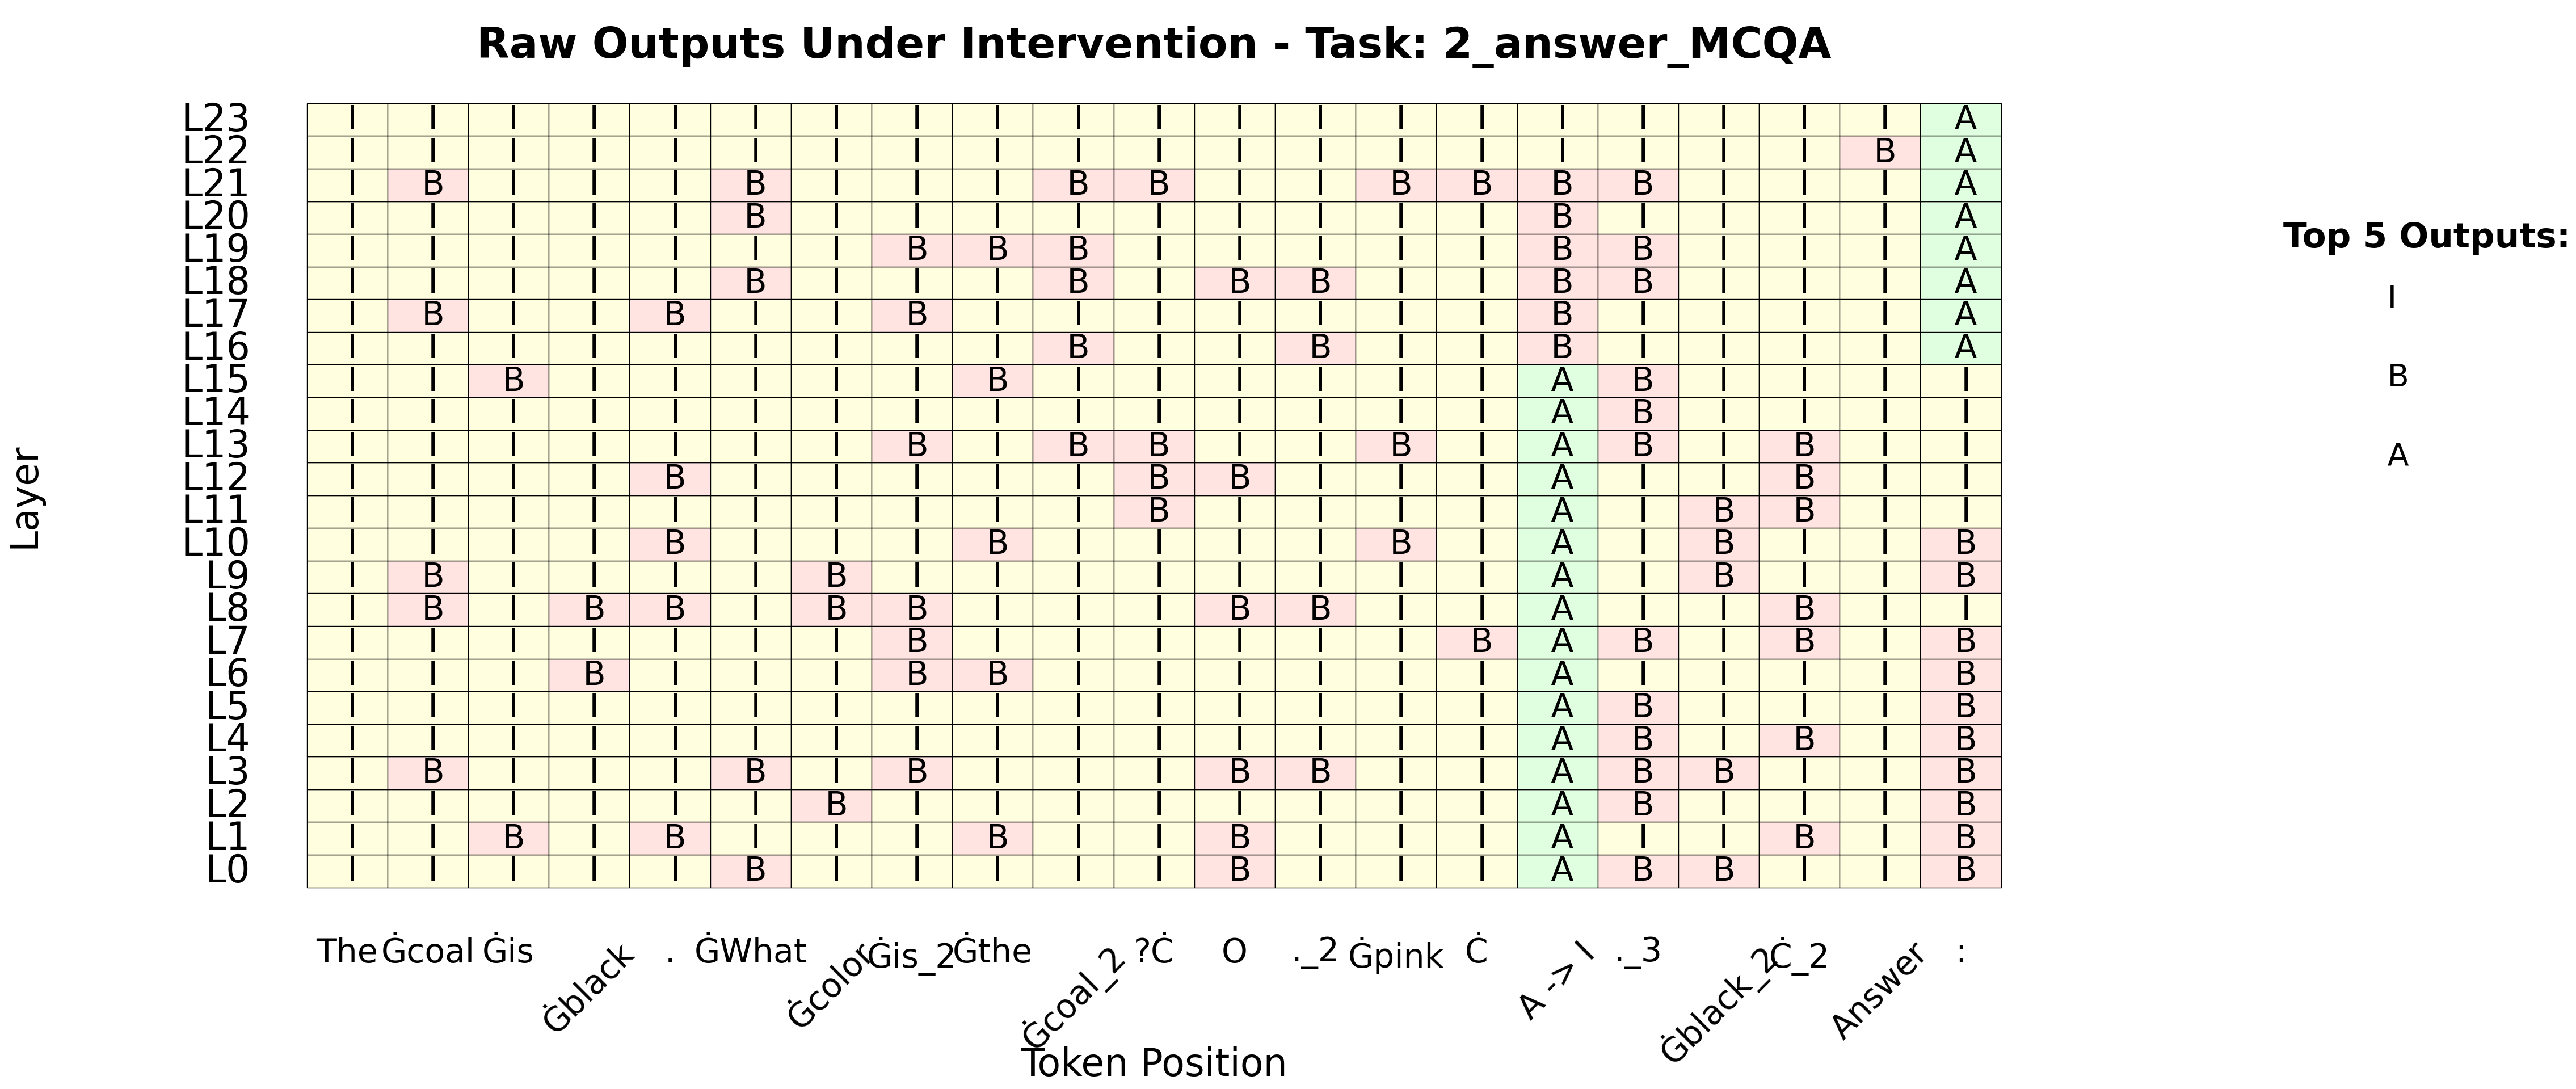


Tracing completed for 4 layer-position combinations


In [ ]:
# Import the tracing experiment
from experiments.LM_experiments.residual_stream_experiment import SameLengthResidualStreamTracing

# Run the tracing experiment
print("\n" + "="*50)
print("Running SameLengthResidualStreamTracing experiment...")
print("="*50)

# Create the tracing experiment
tracing_exp = SameLengthResidualStreamTracing(
    pipeline=pipeline,
    causal_model=causal_model,
    checker=checker,
)

# Run the experiment with our counterfactual pair
results = tracing_exp.run(
    base_input=original,
    counterfactual_input=counterfactual
)

tracing_exp.plot_raw_outputs(results, "./tracing_results/tracing_heatmap.png")
print(f"\nTracing completed for {len(results)} layer-position combinations")

In [ ]:
print(results["dataset"]["tracing_example"]["model_unit"]["[[AtomicModelUnit(id='ResidualStream(Layer-3,Token-.)')]]"])

{'raw_outputs': [{'sequences': tensor([[358]]), 'scores': [tensor([[ 4.2188,  0.7930,  3.1875,  ..., -4.6562, -4.6562, -4.6562]])], 'string': ' I'}], 'causal_model_inputs': [{'base_input': {'choice0': 'pink', 'choice1': 'black', 'object_color': ['coal', 'black'], 'raw_input': 'The coal is black. What color is the coal?\nO. pink\nI. black\nAnswer:', 'symbol0': 'O', 'symbol1': 'I', 'template': 'The <object> is <color>. What color is the <object>?\n<symbol0>. <choice0>\n<symbol1>. <choice1>\nAnswer:'}, 'counterfactual_inputs': [{'choice0': 'pink', 'choice1': 'black', 'object_color': ['coal', 'black'], 'raw_input': 'The coal is black. What color is the coal?\nO. pink\nA. black\nAnswer:', 'symbol0': 'O', 'symbol1': 'A', 'template': 'The <object> is <color>. What color is the <object>?\n<symbol0>. <choice0>\n<symbol1>. <choice1>\nAnswer:'}]}], 'metadata': {'layer': 3, 'position': '.'}, 'feature_indices': {'ResidualStream(Layer-3,Token-.)': None}, 'raw_output': {'scores': [0.0], 'average_scor

# Takeaways

Observe how the signal flows from input to output. At the first layer, its gauranteed that the answer symbol token contains the signal, because that's where embedding occurs. At the last layer, its gauranteed that the last token contains the signal, because that's where unembedding occurs. However, the middle layers must be understood via experimentation!

For most input pairs, you will see the output signal remain in the residual stream of the answer token util layer 15, at which point it hops over to the last token until the final layer. You might also see an effect from answer token residual stream representations above layer 15, or the period token after the answer token between layers 3 and 10. You also might see something else entirely!

Rerun the above cells to sample new inputs and see the resulting traces. This sort of experiment is excellent for exploration and ideation!